In [1]:
from itertools import islice
import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib.pyplot import plot
from ipywidgets import interact, IntSlider

In [2]:
from longstaff_schwartz.stochastic_process import GeometricBrownianMotion

In [3]:
rnd = RandomState(seed=1234)

In [4]:
t = np.linspace(0, 5, 12 * 5)
n = 50
r = 0.0
sigma = 0.15
gbm = GeometricBrownianMotion(mu=r, sigma=sigma)

In [5]:
X = gbm.simulate(t, n, rnd)
X.shape

(60, 50)

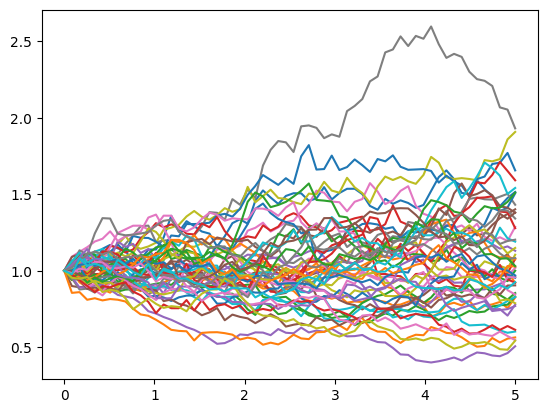

In [6]:
plot(t, X);

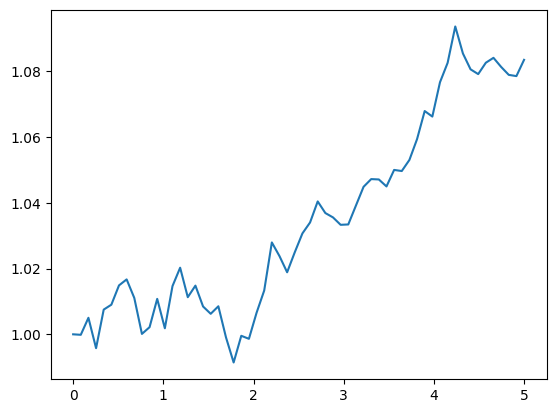

In [7]:
plot(t, X.mean(axis=1));

In [8]:
def exercise_value(s):
    return np.maximum(s - 1, 0)

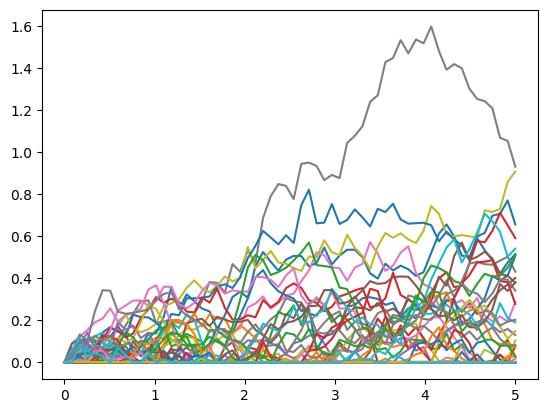

In [9]:
plot(t, exercise_value(X));

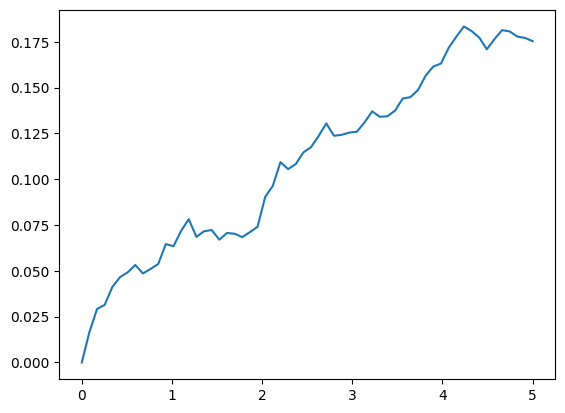

In [10]:
plot(t, exercise_value(X).mean(axis=1));

In [11]:
p = Polynomial([1, 1, 1, 1])
p

Polynomial([1., 1., 1., 1.], domain=[-1,  1], window=[-1,  1])

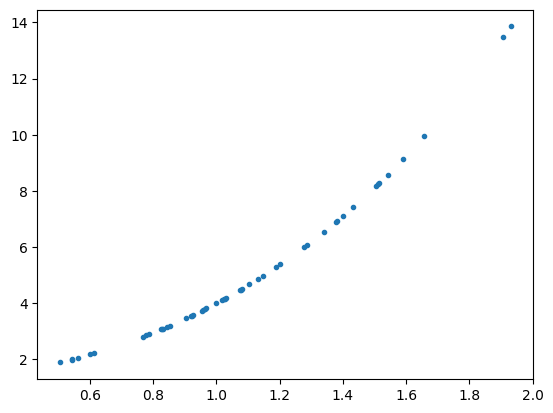

In [12]:
x = X[-1, :]
plot(x, p(x), ".");

In [13]:
def fit(x, y):
    return Polynomial.fit(x, y, 3)

In [14]:
p = fit(x, exercise_value(x))
p

Polynomial([ 0.20778097,  0.64526585,  0.27951733, -0.19790102], domain=[0.50589696, 1.93071881], window=[-1.,  1.])

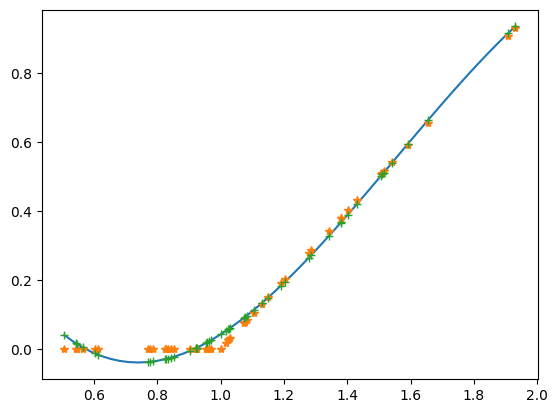

In [15]:
_x = np.linspace(np.min(x), np.max(x))
plot(_x, p(_x))
plot(x, exercise_value(x), "*")
plot(x, p(x), "+");

In [16]:
def backward_regression(fit, exercise_value, X):
    total = exercise_value(X[-1, :])
    for i in reversed(range(1, X.shape[0] - 1)):
        x = X[i, :]
        fitted = fit(x, total)
        exercise = exercise_value(x)
        continuation = fitted(x)
        total = np.maximum(exercise, continuation)
        yield total, x, fitted, continuation, exercise

In [17]:
bw_regr_steps = list(backward_regression(fit, exercise_value, X))

In [18]:
@interact(n_steps=IntSlider(min=1, max=X.shape[0] - 2, value=1))
def step(n_steps):
    total, x, fitted, continuation, exercise = bw_regr_steps[n_steps]
    plot(x, total, "+")
    plot(x, continuation, "*")
    plot(x, exercise, ".");

interactive(children=(IntSlider(value=1, description='n_steps', max=58, min=1), Output()), _dom_classes=('widg…

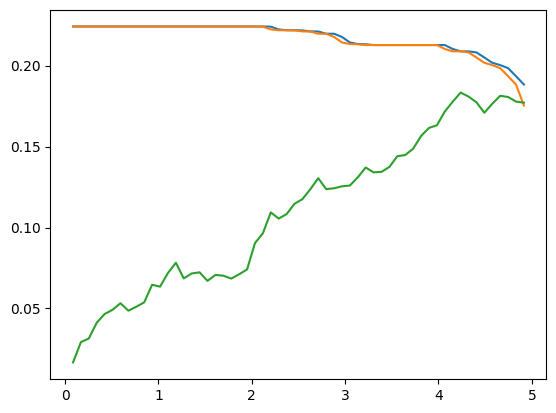

In [19]:
plot(t[1:-1], [np.average(total) for total, *_ in reversed(bw_regr_steps)])
plot(
    t[1:-1],
    [
        np.average(continuation)
        for total, x, fitted, continuation, exercise in reversed(bw_regr_steps)
    ],
)
plot(
    t[1:-1],
    [
        np.average(exercise)
        for total, x, fitted, continuation, exercise in reversed(bw_regr_steps)
    ],
);

In [20]:
for total, x, fitted, continuation, exercise in backward_regression(
    fit, exercise_value, X
):
    print(fitted)

0.24870697093538693 + 0.7245531946610995·x¹ + 0.25431660900471414·x² -
0.2767790299557106·x³
0.24996469942297933 + 0.7393536215930873·x¹ + 0.32696229862644255·x² -
0.2443151225264191·x³
0.32317294699537014 + 0.8353172398851723·x¹ + 0.26484418532528997·x² -
0.34298746341740477·x³
0.34678658558134723 + 0.8728526987770456·x¹ + 0.29664834995918005·x² -
0.3133978881805032·x³
0.3660794360510808 + 0.9267729841415128·x¹ + 0.3035421230292395·x² -
0.34721071527878977·x³
0.4082044412509569 + 1.0598005859790283·x¹ + 0.2887896510875844·x² -
0.4954084890434979·x³
0.43999231524001803 + 1.1103168873336995·x¹ + 0.28724669503616623·x² -
0.5379392598443192·x³
0.444195554488646 + 1.072820071639039·x¹ + 0.31302863615056586·x² -
0.43846330605663003·x³
0.40754298808477757 + 1.011847920988785·x¹ + 0.36282457768707377·x² -
0.3682165555901035·x³
0.4555939128265646 + 1.0593412925579782·x¹ + 0.30951061238663263·x² -
0.41566557082337247·x³
0.5133406067061923 + 1.1213424476530196·x¹ + 0.27725914673016383·x² -
0.436

In [21]:
assert np.average(total) >= np.average(exercise_value(X[-1, :]))
print(np.average(total))
print(np.average(exercise_value(X[-1, :])))

0.22421715549886706
0.1753498176108298
